In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
!pip install POT

In [3]:
pip install --upgrade numpy


In [7]:
import math
import os
import timeit
import math

import numpy as np
import ot
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision.models as models
import pdb
from tqdm import tqdm

from scipy.stats import entropy
from numpy.linalg import norm
from scipy import linalg


def giveName(iter):  # 7 digit name.
    ans = str(iter)
    return ans.zfill(7)


def make_dataset(dataset, dataroot, imageSize):
    """
    :param dataset: must be in 'cifar10 | lsun | imagenet | folder | lfw | fake'
    :return: pytorch dataset for DataLoader to utilize
    """
    if dataset in ['imagenet', 'folder', 'lfw']:
        # folder dataset
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.Resize(imageSize),
                                       transforms.CenterCrop(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    elif dataset == 'lsun':
        dataset = dset.LSUN(db_path=dataroot, classes=['bedroom_train'],
                            transform=transforms.Compose([
                                transforms.Resize(imageSize),
                                transforms.CenterCrop(imageSize),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                            ]))
    elif dataset == 'cifar10':
        dataset = dset.CIFAR10(root=dataroot, download=True,
                               transform=transforms.Compose([
                                   transforms.Resize(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize(
                                       (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    elif dataset == 'celeba':
        dataset = dset.ImageFolder(root=dataroot,
                                   transform=transforms.Compose([
                                       transforms.CenterCrop(138),
                                       transforms.Resize(imageSize),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                   ]))
    else:
        raise Exception('--dataset must be in cifar10 | lsun | imagenet | folder | lfw | fake')
    assert dataset
    return dataset


def sampleFake(netG, nz, sampleSize, batchSize, saveFolder):
    print('sampling fake images ...')
    saveFolder = saveFolder + '0/'

    try:
        os.makedirs(saveFolder)
    except OSError:
        pass

    noise = torch.FloatTensor(batchSize, nz, 1, 1).cuda()
    iter = 0
    for i in range(0, 1 + sampleSize // batchSize):
        noise.data.normal_(0, 1)
        fake = netG(noise)
        for j in range(0, len(fake.data)):
            if iter < sampleSize:
                vutils.save_image(fake.data[j].mul(0.5).add(
                    0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break


def sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize, saveFolder, workers=4):
    print('sampling real images ...')
    saveFolder = saveFolder + '0/'

    dataset = make_dataset(dataset, dataroot, imageSize)
    dataloader = torch.utils.data.DataLoader(
        dataset, shuffle=True, batch_size=batchSize, num_workers=int(workers))

    if not os.path.exists(saveFolder):
        try:
            os.makedirs(saveFolder)
        except OSError:
            pass

    iter = 0
    for i, data in enumerate(dataloader, 0):
        img, _ = data
        for j in range(0, len(img)):

            vutils.save_image(img[j].mul(0.5).add(
                0.5), saveFolder + giveName(iter) + ".png")
            iter += 1
            if iter >= sampleSize:
                break
        if iter >= sampleSize:
            break



class ConvNetFeatureSaver(object):
    def __init__(self, model='resnet34', workers=4, batchSize=64):
        '''
        model: inception_v3, vgg13, vgg16, vgg19, resnet18, resnet34,
               resnet50, resnet101, or resnet152
        '''
        self.model = model
        self.batch_size = batchSize
        self.workers = workers
        if self.model.find('vgg') >= 0:
            self.vgg = getattr(models, model)(pretrained=True).cuda().eval()
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model.find('resnet') >= 0:
            resnet = getattr(models, model)(pretrained=True)
            resnet.cuda().eval()
            resnet_feature = nn.Sequential(resnet.conv1, resnet.bn1,
                                           resnet.relu,
                                           resnet.maxpool, resnet.layer1,
                                           resnet.layer2, resnet.layer3,
                                           resnet.layer4).cuda().eval()
            self.resnet = resnet
            self.resnet_feature = resnet_feature
            self.trans = transforms.Compose([
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406),
                                     (0.229, 0.224, 0.225)),
            ])
        elif self.model == 'inception' or self.model == 'inception_v3':
            inception = models.inception_v3(
                pretrained=True, transform_input=False).cuda().eval()
            inception_feature = nn.Sequential(inception.Conv2d_1a_3x3,
                                              inception.Conv2d_2a_3x3,
                                              inception.Conv2d_2b_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Conv2d_3b_1x1,
                                              inception.Conv2d_4a_3x3,
                                              nn.MaxPool2d(3, 2),
                                              inception.Mixed_5b,
                                              inception.Mixed_5c,
                                              inception.Mixed_5d,
                                              inception.Mixed_6a,
                                              inception.Mixed_6b,
                                              inception.Mixed_6c,
                                              inception.Mixed_6d,
                                              inception.Mixed_7a,
                                              inception.Mixed_7b,
                                              inception.Mixed_7c,
                                              ).cuda().eval()
            self.inception = inception
            self.inception_feature = inception_feature
            self.trans = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
        else:
            raise NotImplementedError

    def save(self, imgFolder, save2disk=False):
        dataset = dset.ImageFolder(root=imgFolder, transform=self.trans)
        dataloader = torch.utils.data.DataLoader(
            dataset, batch_size=self.batch_size, num_workers=self.workers)
        print('extracting features...')
        feature_pixl, feature_conv, feature_smax, feature_logit = [], [], [], []
        for img, _ in tqdm(dataloader):
            with torch.no_grad():
                input = img.cuda()
                if self.model == 'vgg' or self.model == 'vgg16':
                    fconv = self.vgg.features(input).view(input.size(0), -1)
                    flogit = self.vgg.classifier(fconv)
                    # flogit = self.vgg.logitifier(fconv)
                elif self.model.find('resnet') >= 0:
                    fconv = self.resnet_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.resnet.fc(fconv)
                elif self.model == 'inception' or self.model == 'inception_v3':
                    fconv = self.inception_feature(
                        input).mean(3).mean(2).squeeze()
                    flogit = self.inception.fc(fconv)
                else:
                    raise NotImplementedError
                fsmax = F.softmax(flogit)
                feature_pixl.append(img)
                feature_conv.append(fconv.data.cpu())
                feature_logit.append(flogit.data.cpu())
                feature_smax.append(fsmax.data.cpu())

        feature_pixl = torch.cat(feature_pixl, 0).to('cpu')
        feature_conv = torch.cat(feature_conv, 0).to('cpu')
        feature_logit = torch.cat(feature_logit, 0).to('cpu')
        feature_smax = torch.cat(feature_smax, 0).to('cpu')

        if save2disk:
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_pixl.pth'))
            torch.save(feature_conv, os.path.join(
                imgFolder, 'feature_conv.pth'))
            torch.save(feature_logit, os.path.join(
                imgFolder, 'feature_logit.pth'))
            torch.save(feature_smax, os.path.join(
                imgFolder, 'feature_smax.pth'))

        return feature_pixl, feature_conv, feature_logit, feature_smax


def distance(X, Y, sqrt):
    nX = X.size(0)
    nY = Y.size(0)
    X = X.view(nX,-1)
    X2 = (X*X).sum(1).resize_(nX,1)
    Y = Y.view(nY,-1)
    Y2 = (Y*Y).sum(1).resize_(nY,1)

    M = torch.zeros(nX, nY)
    M.copy_(X2.expand(nX, nY) + Y2.expand(nY, nX).transpose(0, 1) -
            2 * torch.mm(X, Y.transpose(0, 1)))

    del X, X2, Y, Y2

    if sqrt:
        M = ((M + M.abs()) / 2).sqrt()

    return M


def wasserstein(M, sqrt):
    if sqrt:
        M = M.abs().sqrt()
    emd = ot.emd2([], [], M.numpy())

    return emd


class Score_knn:
    acc = 0
    acc_real = 0
    acc_fake = 0
    precision = 0
    recall = 0
    tp = 0
    fp = 0
    fn = 0
    tn = 0


def knn(Mxx, Mxy, Myy, k, sqrt):
    n0 = Mxx.size(0)
    n1 = Myy.size(0)
    label = torch.cat((torch.ones(n0), torch.zeros(n1)))
    M = torch.cat((torch.cat((Mxx, Mxy), 1), torch.cat(
        (Mxy.transpose(0, 1), Myy), 1)), 0)
    if sqrt:
        M = M.abs().sqrt()
    INFINITY = float('inf')
    val, idx = (M + torch.diag(INFINITY * torch.ones(n0 + n1))
                ).topk(k, 0, False)

    count = torch.zeros(n0 + n1)
    for i in range(0, k):
        count = count + label.index_select(0, idx[i])
    pred = torch.ge(count, (float(k) / 2) * torch.ones(n0 + n1)).float()

    s = Score_knn()
    s.tp = (pred * label).sum()
    s.fp = (pred * (1 - label)).sum()
    s.fn = ((1 - pred) * label).sum()
    s.tn = ((1 - pred) * (1 - label)).sum()
    s.precision = s.tp / (s.tp + s.fp + 1e-10)
    s.recall = s.tp / (s.tp + s.fn + 1e-10)
    s.acc_real = s.tp / (s.tp + s.fn)
    s.acc_fake = s.tn / (s.tn + s.fp)
    s.acc = torch.eq(label, pred).float().mean()
    s.k = k
    print("Prcision:", s.precision, "Recall:", s.recall, "Accuracy:", s.acc)
    print("\n")
    return s


def mmd(Mxx, Mxy, Myy, sigma):
    scale = Mxx.mean()
    Mxx = torch.exp(-Mxx / (scale * 2 * sigma * sigma))
    Mxy = torch.exp(-Mxy / (scale * 2 * sigma * sigma))
    Myy = torch.exp(-Myy / (scale * 2 * sigma * sigma))
    mmd = math.sqrt(Mxx.mean() + Myy.mean() - 2 * Mxy.mean())
    print("\nMMD Score:",mmd)
    return mmd


def entropy_score(X, Y, epsilons):
    Mxy = distance(X, Y, False)
    scores = []
    for epsilon in epsilons:
        scores.append(ent(Mxy.t(), epsilon))
    print("\nEntropy Score:",scores)
    return scores


def ent(M, epsilon):
    n0 = M.size(0)
    n1 = M.size(1)
    neighbors = M.lt(epsilon).float()
    sums = neighbors.sum(0).repeat(n0, 1)
    sums[sums.eq(0)] = 1
    neighbors = neighbors.div(sums)
    probs = neighbors.sum(1) / n1
    rem = 1 - probs.sum()
    if rem < 0:
        rem = 0
    probs = torch.cat((probs, rem*torch.ones(1)), 0)
    e = {}
    e['probs'] = probs
    probs = probs[probs.gt(0)]
    e['ent'] = -probs.mul(probs.log()).sum()

    return e



eps = 1e-20
def inception_score(X):
    kl = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    score = np.exp(kl.sum(1).mean())
    print("\nInception Score:", score)
    return score

def mode_score(X, Y):
    kl1 = X * ((X+eps).log()-(X.mean(0)+eps).log().expand_as(X))
    kl2 = X.mean(0) * ((X.mean(0)+eps).log()-(Y.mean(0)+eps).log())
    score = np.exp(kl1.sum(1).mean() - kl2.sum())
    print("\n Mode Score:", score)
    return score


def fid(X, Y):
    m = X.mean(0)
    m_w = Y.mean(0)
    X_np = X.numpy()
    Y_np = Y.numpy()

    C = np.cov(X_np.transpose())
    C_w = np.cov(Y_np.transpose())
    C_C_w_sqrt = linalg.sqrtm(C.dot(C_w), True).real

    score = m.dot(m) + m_w.dot(m_w) - 2 * m_w.dot(m) + \
        np.trace(C + C_w - 2 * C_C_w_sqrt)
    print("\nFID:", np.sqrt(score))
    return np.sqrt(score)


class Score:
    emd = 0
    mmd = 0
    knn = None


def compute_score(real, fake, k=1, sigma=1, sqrt=True):

    Mxx = distance(real, real, False)
    Mxy = distance(real, fake, False)
    Myy = distance(fake, fake, False)

    s = Score()
    s.emd = wasserstein(Mxy, sqrt)
    s.mmd = mmd(Mxx, Mxy, Myy, sigma)
    s.knn = knn(Mxx, Mxy, Myy, k, sqrt)

    return s


def compute_score_raw(batchSize, conv_model='resnet34', workers=4):

   # sampleTrue(dataset, imageSize, dataroot, sampleSize, batchSize,
              # saveFolder_r, workers=workers)
   # sampleFake(netG, nz, sampleSize, batchSize, saveFolder_f, )
    saveFolder_f = '/content/drive/My Drive/DCGAN/im/';
    saveFolder_r = '/content/drive/My Drive/LOP_DATASET/train/'; 
    convnet_feature_saver = ConvNetFeatureSaver(model=conv_model,batchSize=batchSize, workers=workers)
    feature_r = convnet_feature_saver.save(saveFolder_r)
    feature_f = convnet_feature_saver.save(saveFolder_f)

    # 4 feature spaces and 7 scores + incep + modescore + fid
    score = np.zeros(4 * 7 + 3)
    for i in range(0, 4):
        print('compute score in space: ' + str(i))
        Mxx = distance(feature_r[i], feature_r[i], False)
        Mxy = distance(feature_r[i], feature_f[i], False)
        Myy = distance(feature_f[i], feature_f[i], False)

        score[i * 7] = wasserstein(Mxy, True)
        score[i * 7 + 1] = mmd(Mxx, Mxy, Myy, 1)
        tmp = knn(Mxx, Mxy, Myy, 1, False)
        score[(i * 7 + 2):(i * 7 + 7)] = \
            tmp.acc, tmp.acc_real, tmp.acc_fake, tmp.precision, tmp.recall

    score[28] = inception_score(feature_f[3])
    score[29] = mode_score(feature_r[3], feature_f[3])
    score[30] = fid(feature_r[3], feature_f[3])
    return score

In [8]:
outf = '/content/drive/My Drive/DCGAN/metrics'

In [9]:
s = compute_score_raw(16, conv_model='inception_v3', workers=int(2))
score_tr = s

extracting features...


100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


extracting features...


100%|██████████| 7/7 [00:18<00:00,  2.63s/it]


compute score in space: 0

MMD Score: 0.11797525754246911
Prcision: tensor(0.9385) Recall: tensor(0.8652) Accuracy: tensor(0.8586)


compute score in space: 1

MMD Score: 0.5155103151342033
Prcision: tensor(1.) Recall: tensor(1.) Accuracy: tensor(1.)


compute score in space: 2

MMD Score: 0.5100673206626466
Prcision: tensor(1.) Recall: tensor(1.) Accuracy: tensor(1.)


compute score in space: 3

MMD Score: 0.27926742291718815
Prcision: tensor(0.9752) Recall: tensor(0.9752) Accuracy: tensor(0.9634)



Inception Score: tensor(1.2210)

 Mode Score: tensor(1.0448)

FID: tensor(0.0949)


In [10]:
# save final metric scores of all epoches
np.save('%s/score_tr_ep.npy' % outf, score_tr)
print('##### training completed :) #####')
print('### metric scores output is scored at %s/score_tr_ep.npy ###' % outf)

##### training completed :) #####
### metric scores output is scored at /content/drive/My Drive/DCGAN/metrics/score_tr_ep.npy ###


In [11]:
new_num_arr = np.load('/content/drive/My Drive/DCGAN/metrics/score_tr_ep.npy') # load
print(new_num_arr)

[1.61647788e+02 1.17975258e-01 8.58638763e-01 8.65248203e-01
 8.39999974e-01 9.38461542e-01 8.65248203e-01 1.03606560e+01
 5.15510315e-01 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 2.07796455e+01 5.10067321e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 8.62556045e-02 2.79267423e-01 9.63350773e-01
 9.75177288e-01 9.30000007e-01 9.75177288e-01 9.75177288e-01
 1.22098470e+00 1.04481685e+00 9.48900133e-02]


In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt
RES_DIR = '/content/drive/My Drive/DCGAN/images/'
FILE_PATH = '%s/generated_%d.png'
images_saved = 0
import cv2
import os

def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        #img = torch.
        #save_image(img, '/content/drive/My Drive/DCGAN/images/sample_%d'%epoch + '.png', nrow=5, normalize=True)
        cv2.imwrite(os.path.join(RES_DIR , 'sample_%d.jpg'%epoch), img)
        #cv2.imwrite(RES_DIR, img)
       # images_saved += 1
        ax.set_adjustable('box')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes


def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x



class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test)*(1 - val_frac))
        self.test_x, self.valid_x = test[:split_idx], test[split_idx:]
        
        self.train_x = train
        
        #self.train_x = np.rollaxis(self.train_x, 3)
        #self.valid_x = np.rollaxis(self.valid_x, 3)
        #self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            
        
        n_batches = len(self.train_x)//batch_size
        for ii in range(0, len(self.train_x), batch_size):
            x = self.train_x[ii:ii+batch_size]
            
            
            yield self.scaler(x)


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z


def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.compat.v1.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)



In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
import matplotlib.pyplot as plt
import datetime

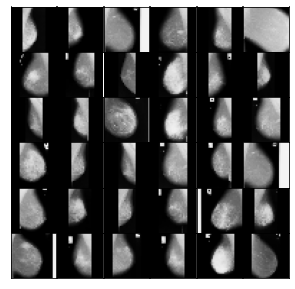

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import os
import cv2
import pickle as pkl

#from model import GAN, generator
#from dataset import Dataset,view_samples

data_dir = '/content/drive/My Drive/LOP_DATASET/train/B/'
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 1000
alpha = 0.2
beta1 = 0.5

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

images=np.array([cv2.resize((cv2.imread("/content/drive/My Drive/LOP_DATASET/train/B/"+tmp, cv2.IMREAD_COLOR)),(32, 32))
                                               for tmp in os.listdir("/content/drive/My Drive/LOP_DATASET/train/B/")])
trainset = images[:3000]
testset = images[3000:]


idx = np.random.randint(0, len(trainset), size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 5 == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                  #  print(gen_samples)
                   # save_image(gen_samples.data[:50], '/content/drive/My Drive/DCGAN/images/sample_%d'%e + '.png', nrow=5, normalize=True)
                    samples.append(gen_samples)
                    for ax, img in zip(axes.flatten(), samples[epochs]):

                      ax.axis('off')
                      img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
                  
                      cv2.imwrite(os.path.join(RES_DIR , 'sample_%d.jpg'%e), img)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, '/content/drive/My Drive/DCGAN/checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples








In [ ]:

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

_ = view_samples(0, samples, 4, 4, figsize=(10,5))


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/normalization.py:424: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalization` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ke

IndexError: ignored